In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/back-order-prediction-dataset/Testing_BOP.csv
/kaggle/input/back-order-prediction-dataset/Training_BOP.csv
/kaggle/input/logstdvif/y.csv
/kaggle/input/logstdvif/x_vif_only.csv


# Reading the Data

In [2]:
train = pd.read_csv("/kaggle/input/back-order-prediction-dataset/Training_BOP.csv")
test = pd.read_csv("/kaggle/input/back-order-prediction-dataset/Testing_BOP.csv")
print(train.shape)
print(test.shape)

(1687861, 23)
(242076, 23)


In [3]:
#Combine into one dataset
merged = pd.concat([train, test])
#remove the two rows of all NA's
merged=merged[pd.notnull(merged['national_inv'])]

In [4]:
print(merged.columns)
merged.head()

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [5]:
print(merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929935 entries, 0 to 242074
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                object 
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), object(8)
memory usage: 353.4+ MB
None


In [6]:
merged.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,1929935.0,496.568259,29573.434344,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1814318.0,7.878627,7.054212,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1929935.0,43.064397,1295.420493,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1929935.0,178.539864,5108.770174,0.0,0.00,0.00,4.00,1510592.0
forecast_6_month,1929935.0,345.465893,9831.562085,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1929935.0,506.606748,14345.430866,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1929935.0,55.368164,1884.377009,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1929935.0,174.663858,5188.855851,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1929935.0,341.565349,9585.030376,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1929935.0,523.577094,14733.265629,0.0,0.00,4.00,47.00,3205172.0


In [7]:
# Total count of -99 
print(merged[merged['perf_12_month_avg']<0]['perf_12_month_avg'].value_counts())
print(merged[merged['perf_6_month_avg']<0]['perf_6_month_avg'].value_counts())

-99.0    140025
Name: perf_12_month_avg, dtype: int64
-99.0    148579
Name: perf_6_month_avg, dtype: int64


In [8]:
#Change the -99 placeholder to NA for perf_6_month_avg and perf_12_month_avg
merged['perf_6_month_avg']=merged['perf_6_month_avg'].replace(-99, np.NaN)
merged['perf_12_month_avg']=merged['perf_12_month_avg'].replace(-99, np.NaN)

In [9]:
merged.replace('?', np.NAN, inplace=True)

In [10]:
merged.isnull().sum()/len(train)*100
# 6.849912% null in lead_time
# we may drop them

sku                  0.000000
national_inv         0.000000
lead_time            6.849912
in_transit_qty       0.000000
forecast_3_month     0.000000
forecast_6_month     0.000000
forecast_9_month     0.000000
sales_1_month        0.000000
sales_3_month        0.000000
sales_6_month        0.000000
sales_9_month        0.000000
min_bank             0.000000
potential_issue      0.000000
pieces_past_due      0.000000
perf_6_month_avg     8.802798
perf_12_month_avg    8.296003
local_bo_qty         0.000000
deck_risk            0.000000
oe_constraint        0.000000
ppap_risk            0.000000
stop_auto_buy        0.000000
rev_stop             0.000000
went_on_backorder    0.000000
dtype: float64

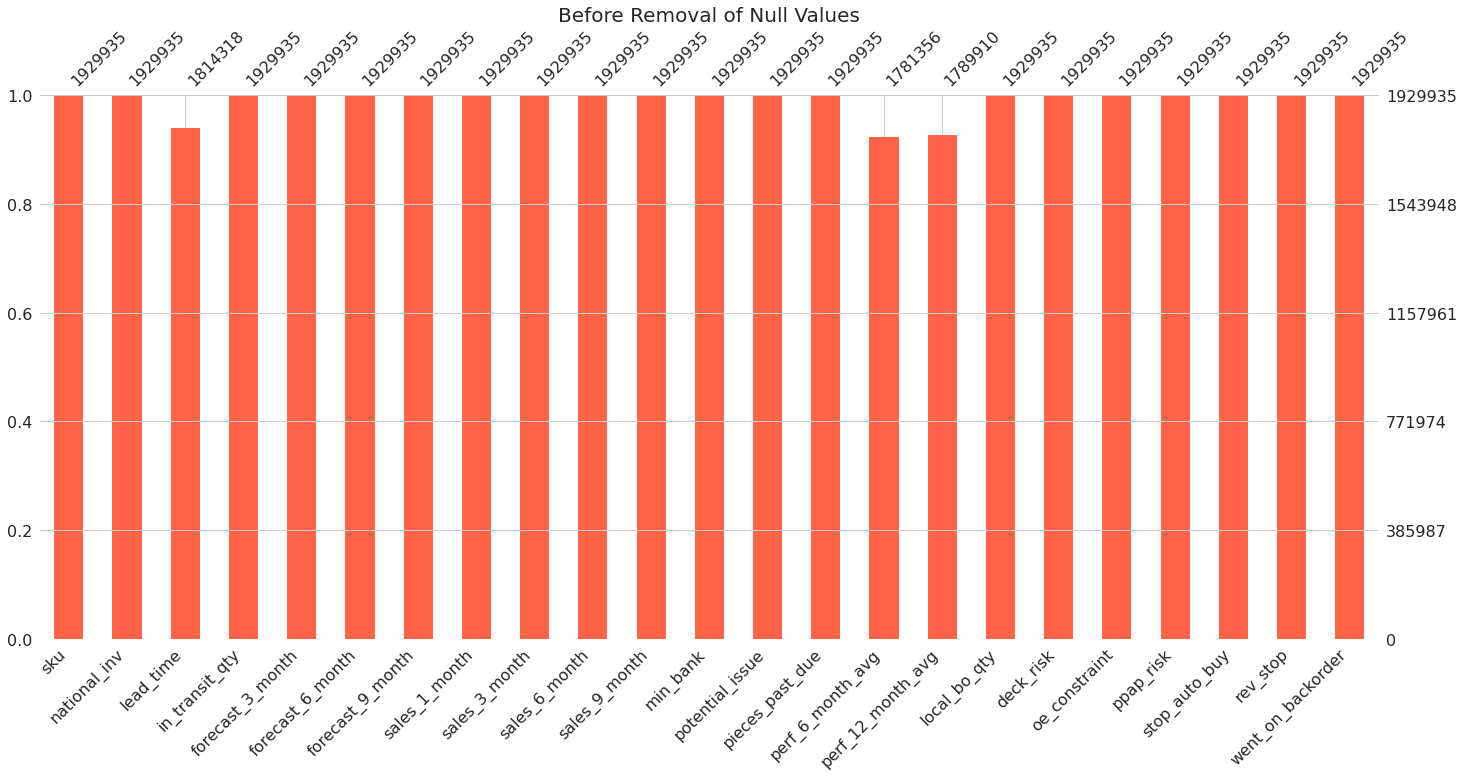

In [11]:
# Visualize our missing data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
plt.figure(figsize=(10,7))
msno.bar(merged, color="tomato")
plt.title("Before Removal of Null Values",fontsize=20)

plt.show()

In [12]:
merged = merged.dropna()

In [13]:
print(merged.isnull().sum())

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


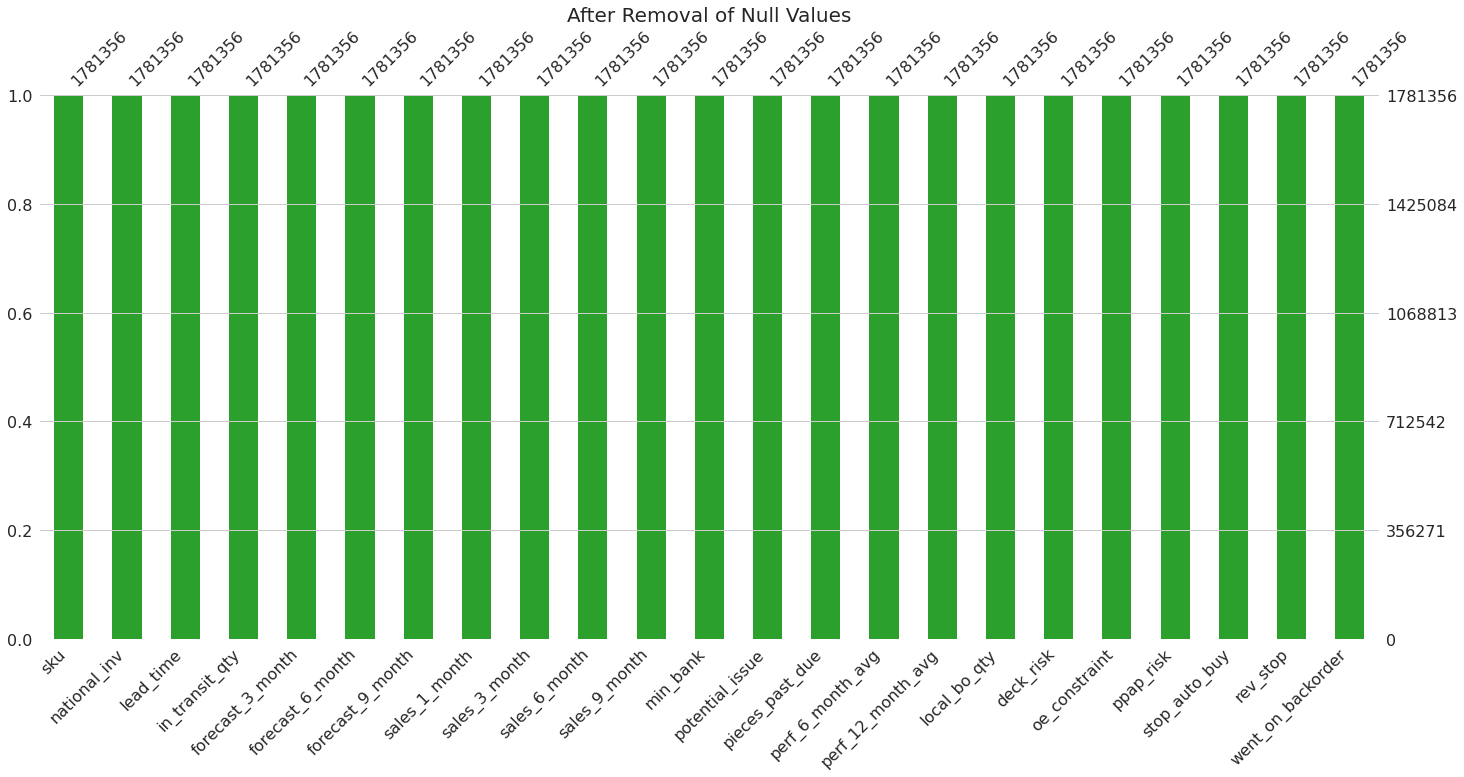

In [14]:
# Visualize our missing data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
plt.figure(figsize=(10,7))
msno.bar(merged, color="tab:green")
plt.title("After Removal of Null Values",fontsize=20)

plt.show()

In [15]:
# Enconding string features to binary
string_features =  ["potential_issue","deck_risk","oe_constraint","ppap_risk","stop_auto_buy","rev_stop"]
string_label = ["went_on_backorder"]
string_columns = string_features+ string_label
yes_no_col =string_columns
print("Before Binary Encoding: ")
for col in yes_no_col:
    print(col,merged[col].unique())
for col in yes_no_col:
    merged[col] = merged[col].map({"Yes" : 1, "No" : 0})
print("After Binary Encoding: ")
for col in yes_no_col:
    print(col,merged[col].unique())

Before Binary Encoding: 
potential_issue ['No' 'Yes']
deck_risk ['No' 'Yes']
oe_constraint ['No' 'Yes']
ppap_risk ['No' 'Yes']
stop_auto_buy ['Yes' 'No']
rev_stop ['No' 'Yes']
went_on_backorder ['No' 'Yes']
After Binary Encoding: 
potential_issue [0 1]
deck_risk [0 1]
oe_constraint [0 1]
ppap_risk [0 1]
stop_auto_buy [1 0]
rev_stop [0 1]
went_on_backorder [0 1]


**backorder: not backorder = 1767929:13427**

``1767929/13427 = 131.66969538988604``

``1767929/3 = 589309.6666666666``

``(1767929/3)/13427 = 43.889898463295346``

``13427 * 44 = 590788``

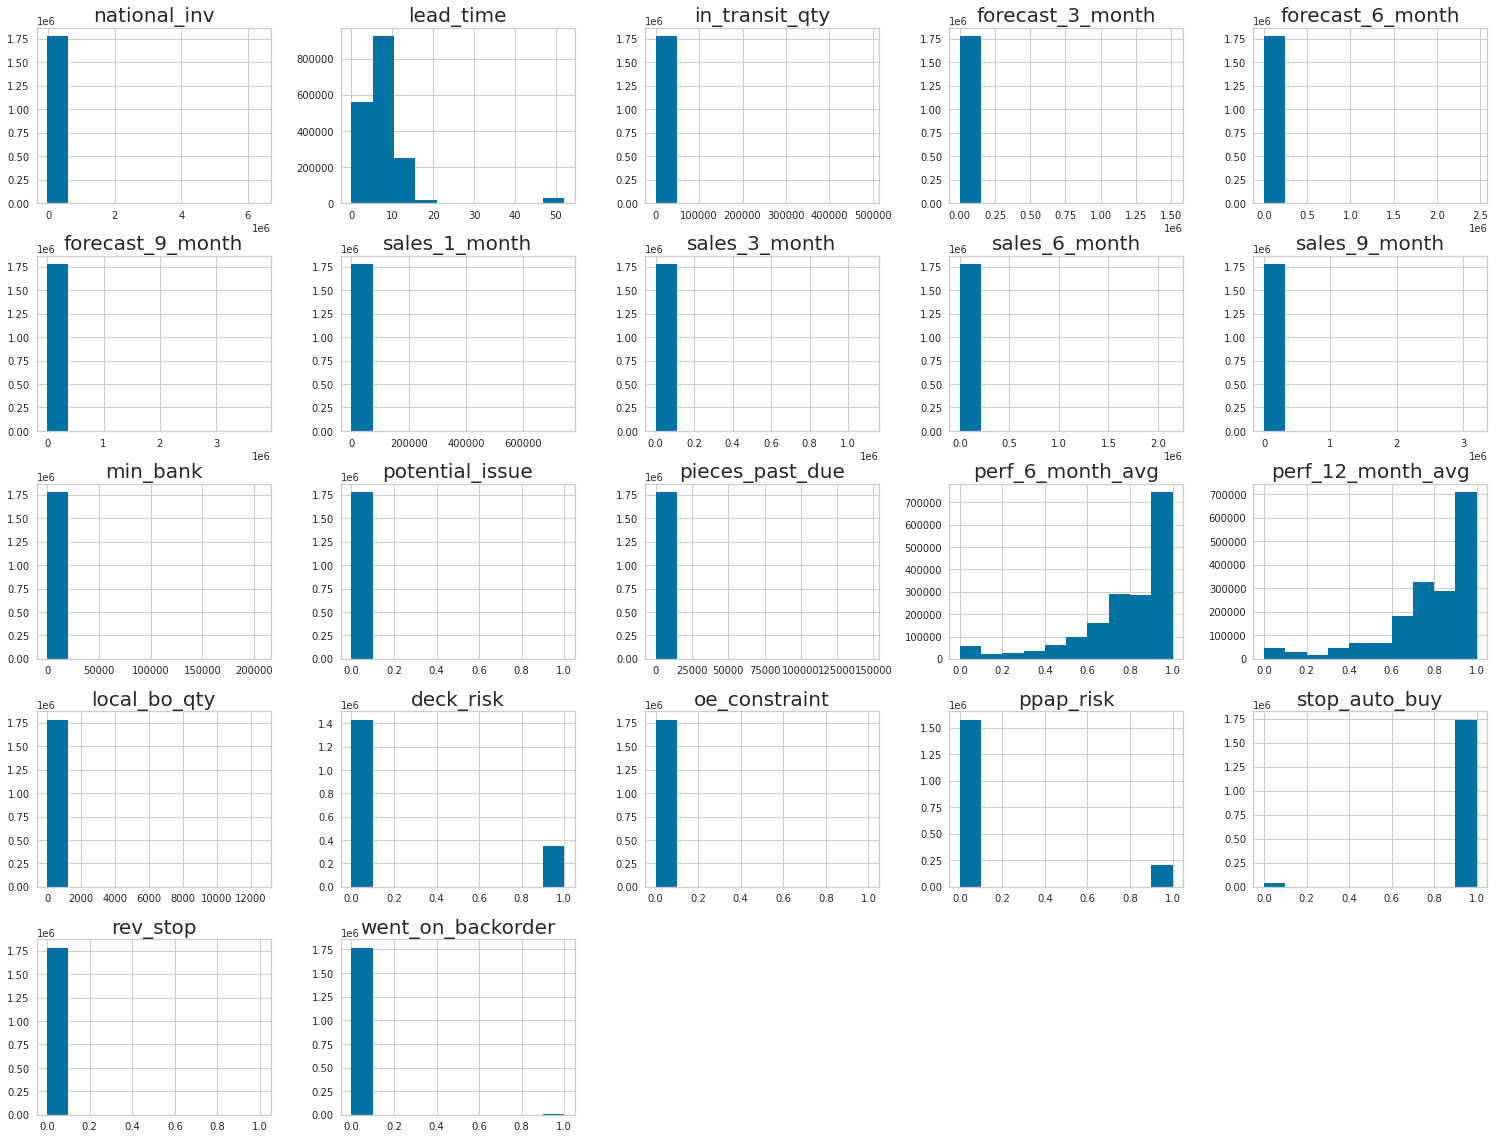

In [16]:
import matplotlib.pyplot as plt

fig = merged.hist(figsize=(26, 20))
fig = [x.title.set_size(20) for x in fig.ravel()]
plt.savefig('features_hist.png') 

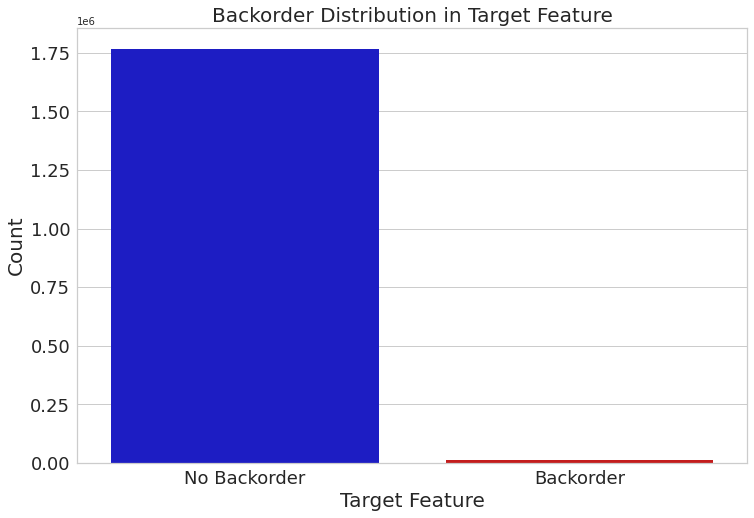

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ["#0101DF", "#DF0101"]

plt.figure(figsize=(12, 8))  # Increase the figure size

sns.countplot('went_on_backorder', data=merged, palette=colors)

# Set title and font size
plt.title('Backorder Distribution in Target Feature', fontsize=20)

# Set font size for labels
# Set font size for labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Set custom tick labels
plt.xticks([0, 1], ['No Backorder', 'Backorder'])
plt.xlabel('Target Feature',fontsize=20)
plt.ylabel('Count',fontsize=20)

plt.show()


In [18]:
columns = ['national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']

In [19]:
'''
fig, ax = plt.subplots(3, 5, figsize=(35,15))
ax=ax.flatten()
columns = ['national_inv', 'lead_time', 'in_transit_qty',
       'forecast_9_month',
       'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop']

for i, j in enumerate(columns):
    val = merged['{}'.format(j)].values
    sns.distplot(val, ax=ax[i], color='r')
    ax[i].set_title('{}'.format(j), fontsize=14)
    ax[i].set_xlim([min(val), max(val)])

plt.show()
'''

"\nfig, ax = plt.subplots(3, 5, figsize=(35,15))\nax=ax.flatten()\ncolumns = ['national_inv', 'lead_time', 'in_transit_qty',\n       'forecast_9_month',\n       'sales_9_month',\n       'min_bank', 'potential_issue', 'pieces_past_due', \n       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',\n       'ppap_risk', 'stop_auto_buy', 'rev_stop']\n\nfor i, j in enumerate(columns):\n    val = merged['{}'.format(j)].values\n    sns.distplot(val, ax=ax[i], color='r')\n    ax[i].set_title('{}'.format(j), fontsize=14)\n    ax[i].set_xlim([min(val), max(val)])\n\nplt.show()\n"

In [20]:
# The classes are heavily skewed we need to solve this issue later.
print('No Backorder', round(merged['went_on_backorder'].value_counts()[0]/len(merged) * 100,2), '% of the dataset')
print('Backorder', round(merged['went_on_backorder'].value_counts()[1]/len(merged) * 100,2), '% of the dataset')

No Backorder 99.25 % of the dataset
Backorder 0.75 % of the dataset


No Backorder 99.25 % of the dataset\
Backorder 0.75 % of the dataset\
**Note:** Notice how imbalanced our original dataset is! Most of the instances are non-backorders. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most instances are not backorders. But we don't want our model to assume, we want our model to detect patterns that give signs of backorders!

# Log transformation

In [21]:
total_col = len(merged.columns)
n_col = 3 
n_row = int(total_col/n_col) if total_col%n_col ==0 else int(np.ceil(total_col/n_col)) 

In [22]:
#applying log1p transformation
log_merged_col =['national_inv','lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank','pieces_past_due' ,'local_bo_qty']
for col in log_merged_col:
    col_name=col+'_log'
    merged[col_name]=np.log(1+merged[col])


In [23]:
total_col

23

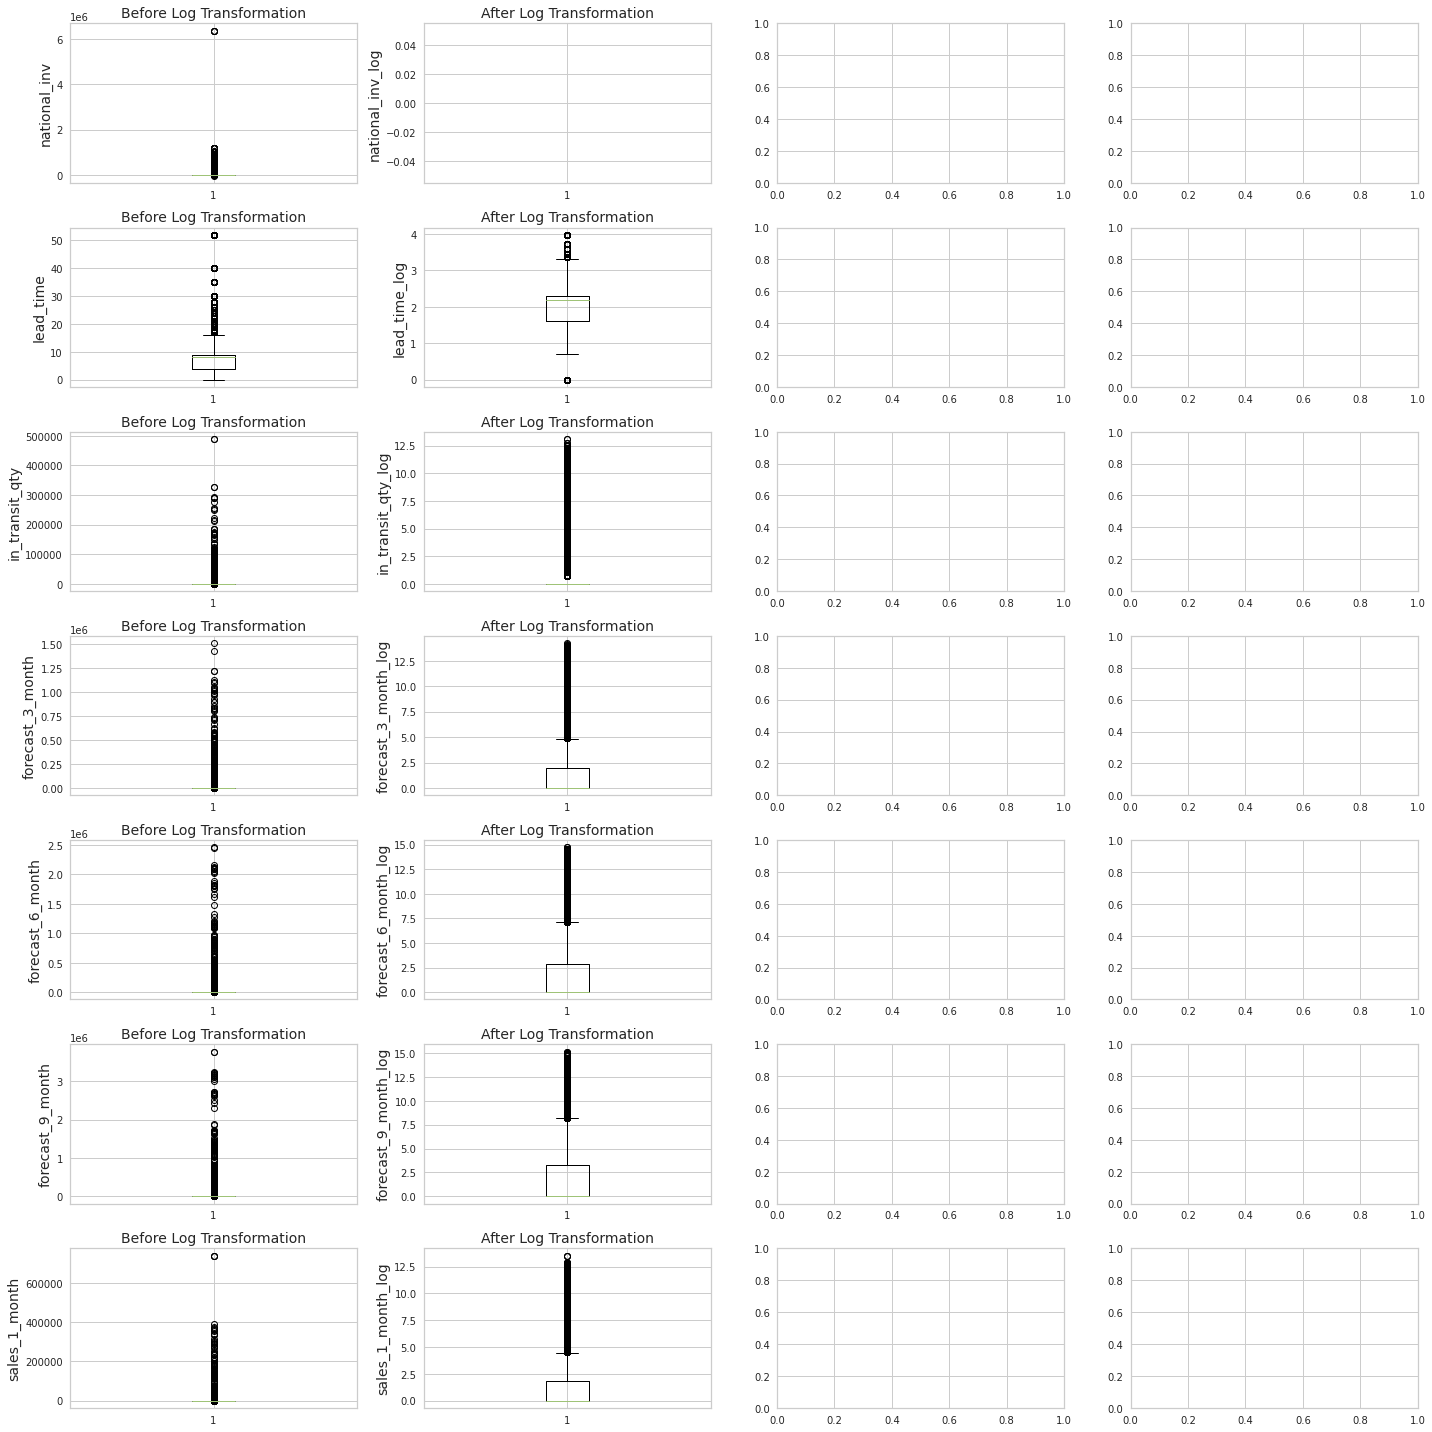

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define variables

total_col = len(log_merged_col) * 2
n_col = 4
n_row = 7 #int(total_col / n_col) if total_col % n_col == 0 else int(np.ceil(total_col / n_col))

# Create subplots
fig, axs = plt.subplots(n_row, n_col, figsize=(20, 20))

merged_col = [i + '_log' for i in log_merged_col]
i = 0

# Iterate over subplots and plot boxplots
for row in range(n_row):
    # Plot boxplot for before log transformation
    axs[row][0].boxplot(merged[[log_merged_col[i]]])
    axs[row][0].set_title('Before Log Transformation', fontsize=14)
    axs[row][0].set_ylabel(log_merged_col[i], fontsize=14)
    
    # Plot boxplot for after log transformation
    axs[row][1].boxplot(merged[[merged_col[i]]])
    axs[row][1].set_title('After Log Transformation', fontsize=14)
    axs[row][1].set_ylabel(merged_col[i], fontsize=14)
    
    i = i + 1

plt.tight_layout()
plt.savefig('log_transform.png')
plt.show()


In [25]:
#dropping the original columns without log
merged.drop(columns=log_merged_col,inplace=True)
merged.columns

Index(['sku', 'potential_issue', 'perf_6_month_avg', 'perf_12_month_avg',
       'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'went_on_backorder', 'national_inv_log', 'lead_time_log',
       'in_transit_qty_log', 'forecast_3_month_log', 'forecast_6_month_log',
       'forecast_9_month_log', 'sales_1_month_log', 'sales_3_month_log',
       'sales_6_month_log', 'sales_9_month_log', 'min_bank_log',
       'pieces_past_due_log', 'local_bo_qty_log'],
      dtype='object')

In [26]:
#check for infinity & null values again after log transformation
merged.isna().sum()

sku                        0
potential_issue            0
perf_6_month_avg           0
perf_12_month_avg          0
deck_risk                  0
oe_constraint              0
ppap_risk                  0
stop_auto_buy              0
rev_stop                   0
went_on_backorder          0
national_inv_log        4667
lead_time_log              0
in_transit_qty_log         0
forecast_3_month_log       0
forecast_6_month_log       0
forecast_9_month_log       0
sales_1_month_log          0
sales_3_month_log          0
sales_6_month_log          0
sales_9_month_log          0
min_bank_log               0
pieces_past_due_log        0
local_bo_qty_log           0
dtype: int64

In [27]:
merged.replace([np.inf, -np.inf], np.nan,inplace=True)
merged.isna().sum()

sku                        0
potential_issue            0
perf_6_month_avg           0
perf_12_month_avg          0
deck_risk                  0
oe_constraint              0
ppap_risk                  0
stop_auto_buy              0
rev_stop                   0
went_on_backorder          0
national_inv_log        6038
lead_time_log              0
in_transit_qty_log         0
forecast_3_month_log       0
forecast_6_month_log       0
forecast_9_month_log       0
sales_1_month_log          0
sales_3_month_log          0
sales_6_month_log          0
sales_9_month_log          0
min_bank_log               0
pieces_past_due_log        0
local_bo_qty_log           0
dtype: int64

In [28]:
merged.dropna(inplace=True)

In [29]:
merged.isna().sum()

sku                     0
potential_issue         0
perf_6_month_avg        0
perf_12_month_avg       0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
national_inv_log        0
lead_time_log           0
in_transit_qty_log      0
forecast_3_month_log    0
forecast_6_month_log    0
forecast_9_month_log    0
sales_1_month_log       0
sales_3_month_log       0
sales_6_month_log       0
sales_9_month_log       0
min_bank_log            0
pieces_past_due_log     0
local_bo_qty_log        0
dtype: int64

# Correlation

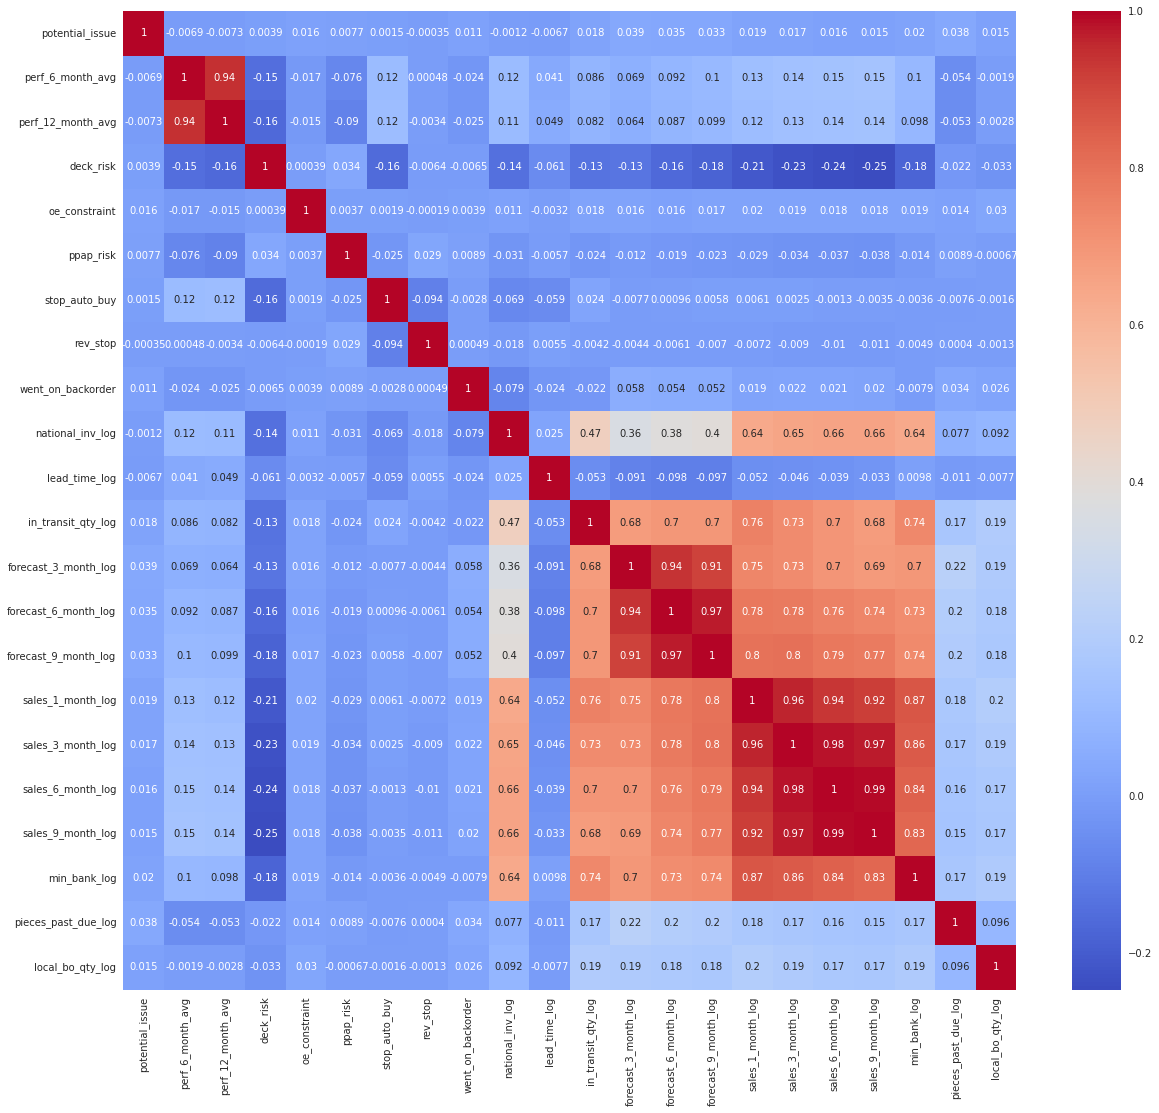

In [30]:
# Correlation matrix
plt.figure(figsize= (20,18))
heat_map = sns.heatmap(merged.corr(), annot= True, cmap= 'coolwarm')
fig = heat_map.get_figure()

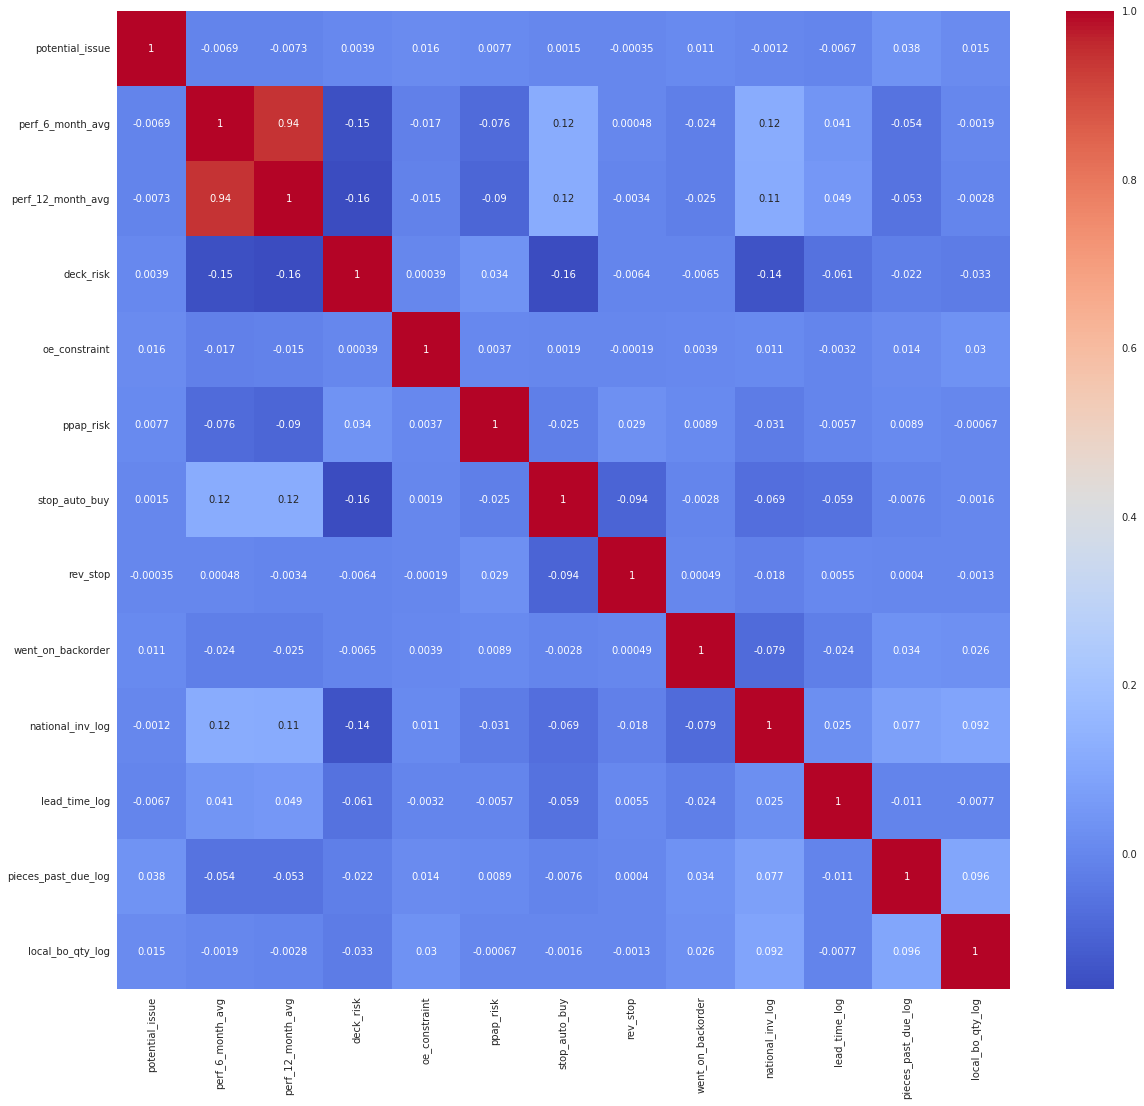

In [31]:
# Correlation matrix
plt.figure(figsize= (20,18))
useful_cols = merged.copy().drop(['in_transit_qty_log','forecast_3_month_log',
                                'forecast_6_month_log', 'forecast_9_month_log',
                                'sales_1_month_log', 'sales_3_month_log',
                                'sales_6_month_log', 'sales_9_month_log', 
                                'min_bank_log'], axis=1)
heat_map = sns.heatmap(useful_cols.corr(), annot= True, cmap= 'coolwarm')
fig = heat_map.get_figure()
#fig.savefig("correlation.png") 

### Removing '_log' from the columns 

In [32]:
merged.drop(columns=['sku'],inplace=True)

In [33]:
print(merged_col)
print()
merged_col_no_log=[ele.split('_log')[0]  for ele in merged_col]
print(merged_col_no_log)
print()
print(dict(zip(merged_col,merged_col_no_log)))

['national_inv_log', 'lead_time_log', 'in_transit_qty_log', 'forecast_3_month_log', 'forecast_6_month_log', 'forecast_9_month_log', 'sales_1_month_log', 'sales_3_month_log', 'sales_6_month_log', 'sales_9_month_log', 'min_bank_log', 'pieces_past_due_log', 'local_bo_qty_log']

['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'local_bo_qty']

{'national_inv_log': 'national_inv', 'lead_time_log': 'lead_time', 'in_transit_qty_log': 'in_transit_qty', 'forecast_3_month_log': 'forecast_3_month', 'forecast_6_month_log': 'forecast_6_month', 'forecast_9_month_log': 'forecast_9_month', 'sales_1_month_log': 'sales_1_month', 'sales_3_month_log': 'sales_3_month', 'sales_6_month_log': 'sales_6_month', 'sales_9_month_log': 'sales_9_month', 'min_bank_log': 'min_bank', 'pieces_past_due_log': 'pieces_past_due', 'local_bo_qty_log': 'local_bo_qty'}


In [34]:
#removing '_log' from column names added during log transformation 
merged.rename(columns=dict(zip(merged_col,merged_col_no_log)),inplace=True)
merged.columns

Index(['potential_issue', 'perf_6_month_avg', 'perf_12_month_avg', 'deck_risk',
       'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'went_on_backorder', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'local_bo_qty'],
      dtype='object')

### StandardScaler

In [35]:
merged.reset_index(drop=True,inplace=True)
merged.columns

Index(['potential_issue', 'perf_6_month_avg', 'perf_12_month_avg', 'deck_risk',
       'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'went_on_backorder', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'local_bo_qty'],
      dtype='object')

In [36]:
X = merged.drop(["went_on_backorder"],axis=1)
y = merged["went_on_backorder"]

In [37]:
merged.columns

Index(['potential_issue', 'perf_6_month_avg', 'perf_12_month_avg', 'deck_risk',
       'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'went_on_backorder', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'local_bo_qty'],
      dtype='object')

In [38]:
X_num=X.drop(columns=string_features)
print(X_num.columns)
print()
X_cat=X[string_features]
print(X_cat.columns)

Index(['perf_6_month_avg', 'perf_12_month_avg', 'national_inv', 'lead_time',
       'in_transit_qty', 'forecast_3_month', 'forecast_6_month',
       'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month',
       'sales_9_month', 'min_bank', 'pieces_past_due', 'local_bo_qty'],
      dtype='object')

Index(['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
       'stop_auto_buy', 'rev_stop'],
      dtype='object')


In [39]:
#scaling numerical columns
from sklearn.preprocessing import StandardScaler, RobustScaler
scalar = StandardScaler()
#rob_scaler = RobustScaler()
X_num_scaled = pd.DataFrame(scalar.fit_transform(X_num),columns=X_num.columns)

In [40]:
X_num_scaled

,perf_6_month_avg,perf_12_month_avg,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty
0,0.876011,0.925708,-1.024682,0.520024,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.665307,-0.105932,-0.084376
1,-2.880112,-2.847583,-0.524955,0.344253,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.257233,-0.105932,-0.084376
2,0.158549,0.399202,-0.239834,0.344253,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.665307,-0.105932,-0.084376
3,-3.302149,-3.417964,-0.592988,-1.488533,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.665307,-0.105932,-0.084376
4,0.158549,0.399202,-0.764419,0.344253,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.665307,-0.105932,-0.084376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775313,-1.276374,-1.311941,-0.277592,0.957719,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.257233,-0.105932,-0.084376
1775314,-1.276374,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.257233,-0.105932,-0.084376
1775315,-1.276374,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.257233,-0.105932,-0.084376
1775316,-1.276374,-1.311941,-0.362705,0.957719,-0.43232,-0.571375,-0.647611,-0.689367,-0.655055,-0.799439,-0.892973,-0.947434,-0.257233,-0.105932,-0.084376


In [41]:
X_num_scaled.shape

(1775318, 15)

In [42]:
X_num_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
perf_6_month_avg,1775318.0,1.552828e-14,1.0,-3.302149,-0.347894,0.285160,0.791604,0.918215
perf_12_month_avg,1775318.0,-2.545822e-15,1.0,-3.417964,-0.346681,0.223700,0.794082,0.969583
national_inv,1775318.0,3.393692e-15,1.0,-1.584418,-0.764419,-0.204683,0.635299,6.397342
lead_time,1775318.0,8.819372e-14,1.0,-3.321320,-0.636336,0.344253,0.520024,3.302216
in_transit_qty,1775318.0,1.577024e-13,1.0,-0.432320,-0.432320,-0.432320,-0.432320,8.360826
forecast_3_month,1775318.0,-4.928899e-14,1.0,-0.571375,-0.571375,-0.571375,0.302822,6.370454
forecast_6_month,1775318.0,2.956196e-14,1.0,-0.647611,-0.647611,-0.647611,0.572648,5.690637
forecast_9_month,1775318.0,-1.722639e-14,1.0,-0.689367,-0.689367,-0.689367,0.624630,5.418447
sales_1_month,1775318.0,-1.200913e-14,1.0,-0.655055,-0.655055,-0.655055,0.430698,7.535723
sales_3_month,1775318.0,7.066281e-16,1.0,-0.799439,-0.799439,-0.462352,0.578389,5.967988


## VIF Approach

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [44]:
calc_vif(X_num_scaled)

,variables,VIF
0,perf_6_month_avg,9.185144
1,perf_12_month_avg,9.171186
2,national_inv,2.072362
3,lead_time,1.034353
4,in_transit_qty,2.724851
5,forecast_3_month,8.982108
6,forecast_6_month,28.793083
7,forecast_9_month,21.695963
8,sales_1_month,16.717665
9,sales_3_month,52.449004


In [45]:
#VIF Treatment 
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Defining the function that you will run later
from datetime import datetime 
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5):   
        now = datetime.now()
        date = now.date()
        current_time = now.strftime("%H:%M:%S")
        variables = [X.columns[i] for i in range(X.shape[1])]
        dropped=True
        while dropped:
            dropped=False
            print(len(variables))
            vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) 
                                                for ix in range(len(variables)))

            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print(str(current_time) + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                variables.pop(maxloc)
                dropped=True

        print('Remaining variables:')
        print([variables])
        return (variables)

final_list_columns=calculate_vif_(X_num_scaled, 5) # 6 or 9 or 10

15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   30.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   36.7s finished


07:24:19 dropping 'sales_6_month' at index: 10
14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  14 | elapsed:   24.0s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   28.8s finished


07:24:19 dropping 'sales_3_month' at index: 9
13


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  13 | elapsed:   20.3s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   24.3s finished


07:24:19 dropping 'forecast_6_month' at index: 6
12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:   13.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   19.1s finished


07:24:19 dropping 'sales_1_month' at index: 7
11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   11.8s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.7s finished


07:24:19 dropping 'perf_6_month_avg' at index: 0
10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.3s finished


07:24:19 dropping 'forecast_9_month' at index: 5
9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    7.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.0s finished


Remaining variables:
[['perf_12_month_avg', 'national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'local_bo_qty']]


In [46]:
final_list_columns

['perf_12_month_avg',
 'national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'local_bo_qty']

# Final data

In [47]:
X_cat

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,1,0,1,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
1775313,0,1,0,0,1,0
1775314,0,1,0,0,1,0
1775315,0,1,0,0,1,0
1775316,0,1,0,0,1,0


In [48]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1775313    0
1775314    0
1775315    0
1775316    0
1775317    0
Name: went_on_backorder, Length: 1775318, dtype: int64

In [49]:
X_num_scaled[final_list_columns]

,perf_12_month_avg,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty
0,0.925708,-1.024682,0.520024,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376
1,-2.847583,-0.524955,0.344253,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376
2,0.399202,-0.239834,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376
3,-3.417964,-0.592988,-1.488533,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376
4,0.399202,-0.764419,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376
...,...,...,...,...,...,...,...,...,...
1775313,-1.311941,-0.277592,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376
1775314,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376
1775315,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376
1775316,-1.311941,-0.362705,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376


In [50]:
principal_x = pd.concat([X_num_scaled[final_list_columns],X_cat.reset_index(drop=True)],axis=1)
principal_x

,perf_12_month_avg,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0.925708,-1.024682,0.520024,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
1,-2.847583,-0.524955,0.344253,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,0,0,0,1,0
2,0.399202,-0.239834,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
3,-3.417964,-0.592988,-1.488533,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,1,0,1,1,0
4,0.399202,-0.764419,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775313,-1.311941,-0.277592,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775314,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775315,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775316,-1.311941,-0.362705,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0


In [51]:
principal_x = principal_x.dropna()
principal_x

,perf_12_month_avg,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_9_month,min_bank,pieces_past_due,local_bo_qty,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0.925708,-1.024682,0.520024,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
1,-2.847583,-0.524955,0.344253,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,0,0,0,1,0
2,0.399202,-0.239834,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
3,-3.417964,-0.592988,-1.488533,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,1,0,1,1,0
4,0.399202,-0.764419,0.344253,-0.43232,-0.571375,-0.947434,-0.665307,-0.105932,-0.084376,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775313,-1.311941,-0.277592,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775314,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775315,-1.311941,-0.239834,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0
1775316,-1.311941,-0.362705,0.957719,-0.43232,-0.571375,-0.947434,-0.257233,-0.105932,-0.084376,0,1,0,0,1,0


In [52]:
y = y.iloc[principal_x.index]
y

0          0
1          0
2          0
3          0
4          0
          ..
1775313    0
1775314    0
1775315    0
1775316    0
1775317    0
Name: went_on_backorder, Length: 1775318, dtype: int64

In [53]:
principal_x.to_csv('x_vif_only.csv')

In [54]:
y.to_csv('y.csv')

## SMOTE

### Before SMOTE

In [55]:
import pandas as pd
principal_x = pd.read_csv("../input/logstdvif/x_vif_only.csv")
principal_x.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("../input/logstdvif/y.csv", index_col=None)['went_on_backorder']

In [56]:
merged = pd.concat([principal_x,y],axis=1)

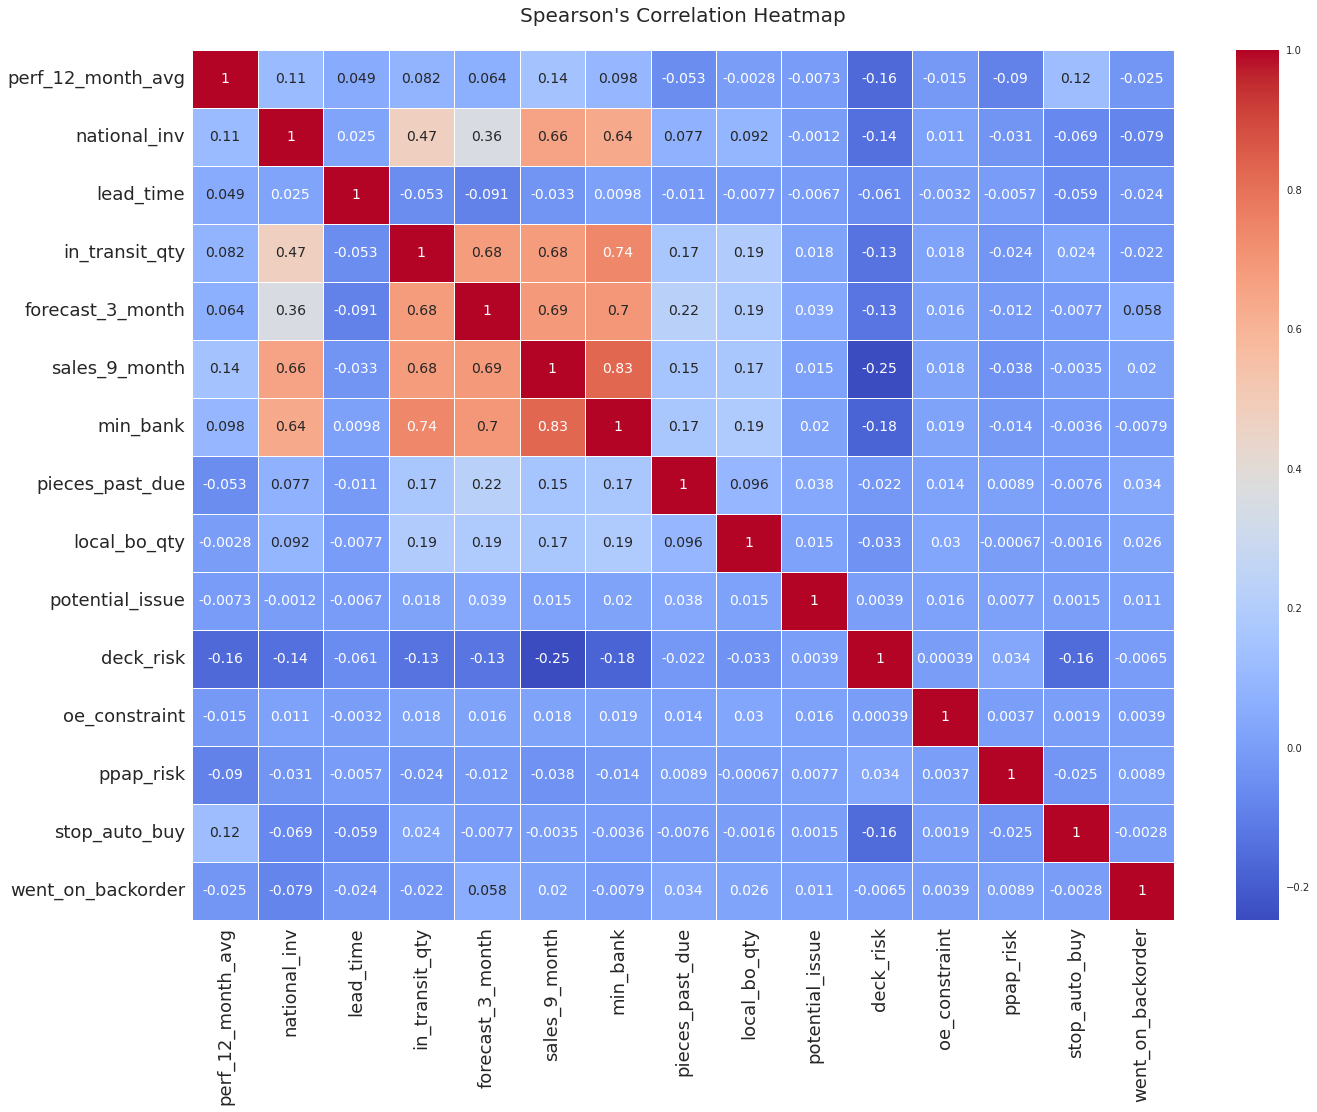

In [58]:
# Correlation matrix

plt.figure(figsize= (22,16))
useful_cols = merged.copy()
sns.heatmap(useful_cols.corr(), annot= True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"fontsize": 14})
# Set the title
plt.title("Spearson\'s Correlation Heatmap\n",fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fig.savefig("correlation2.png", bbox_inches='tight') 

In [59]:
y.value_counts()

0    1762824
1      12494
Name: went_on_backorder, dtype: int64

In [60]:
import sklearn
from sklearn import * 
from collections import Counter
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(principal_x,y,test_size=1 / 3,random_state=0)   
# Check the number of records
print('The number of records in the training dataset is', x_train.shape[0])
print('The number of records in the test dataset is', x_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 1183545
The number of records in the test dataset is 591773
The training dataset has 1175281 records for the majority class and 8264 records for the minority class.


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
model_params = {
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model name' :model_name,
        'model': clf.best_estimator_,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'ROC_AUC' : sklearn.metrics.roc_auc_score(y_test,clf.best_estimator_.predict(x_test))
    })
    
df1 = pd.DataFrame(scores,columns=['model name','model','best_score','best_params','ROC_AUC'])
print(df1)

# print classification report
print(classification_report(y_test, clf.best_estimator_.predict(x_test)))

            model name                                        model  \
0  logistic_regression  LogisticRegression(C=5, solver='liblinear')   

   best_score best_params   ROC_AUC  
0    0.992789    {'C': 5}  0.518151  
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    587543
           1       0.44      0.04      0.07      4230

    accuracy                           0.99    591773
   macro avg       0.71      0.52      0.53    591773
weighted avg       0.99      0.99      0.99    591773



## NearMiss

In [62]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss(sampling_strategy={0: 8264*3}) # downsample majority class
x_train_miss, y_train_miss = nr.fit_resample(x_train, y_train)

print('After Undersampling, the shape of train_X: {}'.format(x_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 8264
Before Undersampling, counts of label '0': 1175281 

After Undersampling, the shape of train_X: (33056, 14)
After Undersampling, the shape of train_y: (33056,) 

After Undersampling, counts of label '1': 8264
After Undersampling, counts of label '0': 24792


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
model_params = {
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train_miss, y_train_miss)
    scores.append({
        'model name' :model_name,
        'model': clf.best_estimator_,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'ROC_AUC' : sklearn.metrics.roc_auc_score(y_test,clf.best_estimator_.predict(x_test))
    })
    
df1 = pd.DataFrame(scores,columns=['model name','model','best_score','best_params','ROC_AUC'])
print(df1)

# print classification report
print(classification_report(y_test, clf.best_estimator_.predict(x_test)))

            model name                                         model  \
0  logistic_regression  LogisticRegression(C=10, solver='liblinear')   

   best_score best_params   ROC_AUC  
0    0.896357   {'C': 10}  0.659111  
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    587543
           1       0.01      0.72      0.02      4230

    accuracy                           0.60    591773
   macro avg       0.50      0.66      0.38    591773
weighted avg       0.99      0.60      0.74    591773



# Log+StandardScaler+VIF

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/back-order-prediction-dataset/Testing_BOP.csv
/kaggle/input/back-order-prediction-dataset/Training_BOP.csv
/kaggle/input/logstdvif/y.csv
/kaggle/input/logstdvif/x_vif_only.csv


In [65]:
X = pd.read_csv("../input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("../input/logstdvif/y.csv", index_col=None)['went_on_backorder']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No backorder', round(y.value_counts()[0]/len(y) * 100,2), '% of the dataset')
print('Backorder', round(y.value_counts()[1]/len(y) * 100,2), '% of the dataset')

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No backorder 99.3 % of the dataset
Backorder 0.7 % of the dataset
Train: [ 259572  259620  259654 ... 1775315 1775316 1775317] Test: [     0      1      2 ... 355895 355896 355897]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [259572 259620 259654 ... 711229 711230 711231]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 562975  562992  563216 ... 1066527 1066528 1066529]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 913555  913679  913781 ... 1549977 1550291 1550807]
Train: [      0       1       2 ... 1549977 1550291 1550807] Test: [1420136 1420137 1420138 ... 1775315 1775316 1775317]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99296253 0.00703747]
[0.99296181 0.00703819]


In [66]:
y.value_counts()[1]

12494

## Anomaly Detection

In [3]:
X = pd.read_csv("../input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("../input/logstdvif/y.csv", index_col=None)['went_on_backorder']

merged = pd.concat([X,y],axis=1)

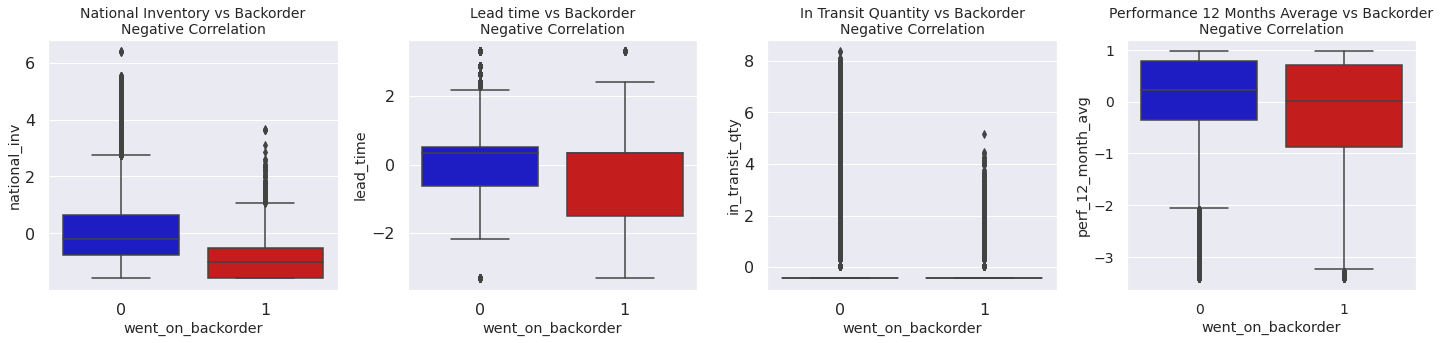

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

new_df=merged

# Set larger font size
plt.rcParams['font.size'] = 20
sns.set(font_scale=1.2)
colors = ["#0101DF", "#DF0101"]
f, axes = plt.subplots(ncols=4, figsize=(20,5))
# Negative Correlations with our went_on_backorder (The lower our feature value the more likely it will be a backorder transaction)
sns.boxplot(x="went_on_backorder", y="national_inv", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('National Inventory vs Backorder\nNegative Correlation', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="lead_time", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Lead time vs Backorder\nNegative Correlation', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="in_transit_qty", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('In Transit Quantity vs Backorder\nNegative Correlation', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="perf_12_month_avg", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Performance 12 Months Average vs Backorder\nNegative Correlation', fontsize=14)
axes[3].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


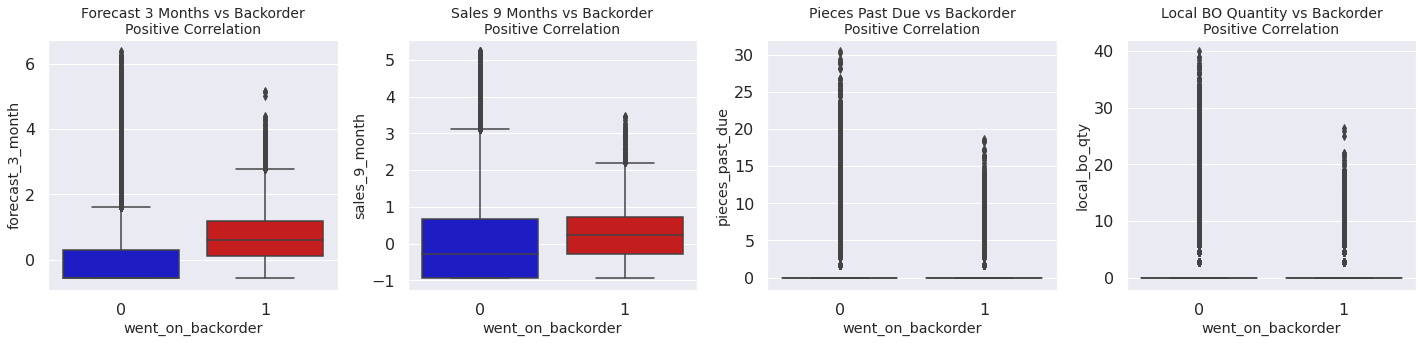

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(20,5))

# Positive correlations (The higher the feature the probability increases that it will be a backorder transaction)
sns.boxplot(x="went_on_backorder", y="forecast_3_month", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Forecast 3 Months vs Backorder\nPositive Correlation', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="sales_9_month", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Sales 9 Months vs Backorder\nPositive Correlation', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="pieces_past_due", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Pieces Past Due vs Backorder\nPositive Correlation', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=16)

sns.boxplot(x="went_on_backorder", y="local_bo_qty", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Local BO Quantity vs Backorder\nPositive Correlation', fontsize=14)
axes[3].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

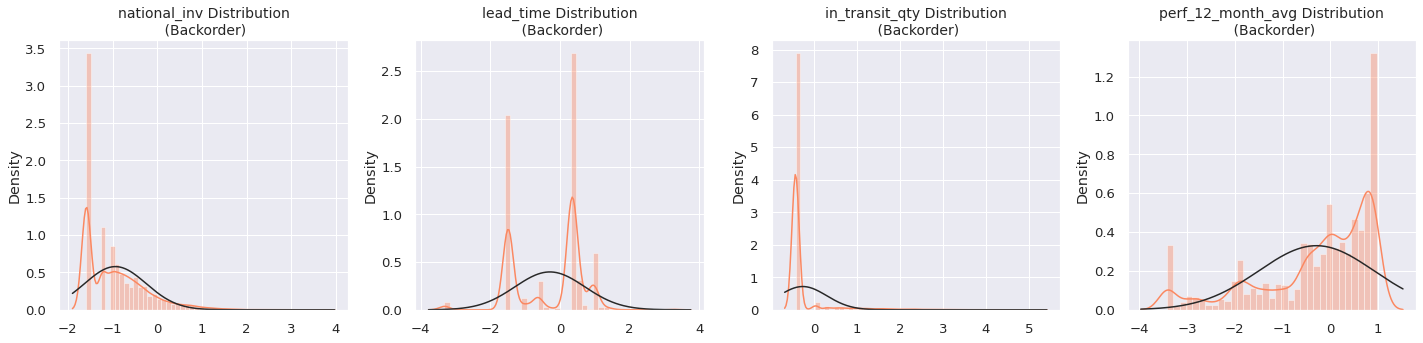

In [25]:
from scipy.stats import norm

f, ax = plt.subplots(1,4, figsize=(20, 5))
ax=ax.flatten()

col=["national_inv","lead_time","in_transit_qty","perf_12_month_avg"]
for i, j in enumerate(col):
    v_dist = new_df[j].loc[new_df['went_on_backorder'] == 1].values
    sns.distplot(v_dist,ax=ax[i], fit=norm, color='#FB8861')
    ax[i].set_title('{} Distribution\n (Backorder)'.format(j), fontsize=14)
plt.tight_layout()
plt.show()

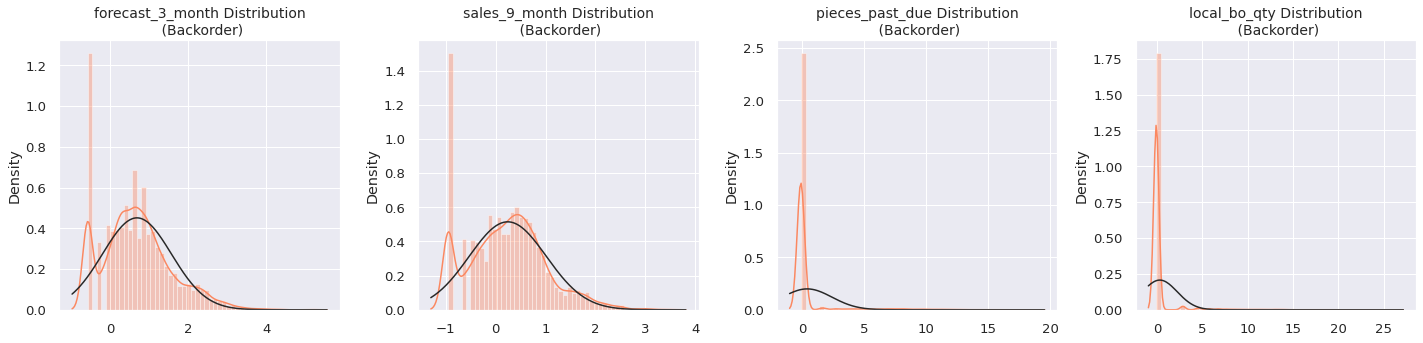

In [26]:
from scipy.stats import norm

f, ax = plt.subplots(1,4, figsize=(20, 5))
ax=ax.flatten()

col=['forecast_3_month','sales_9_month','pieces_past_due','local_bo_qty']
for i, j in enumerate(col):
    v_dist = new_df[j].loc[new_df['went_on_backorder'] == 1].values
    sns.distplot(v_dist,ax=ax[i], fit=norm, color='#FB8861')
    ax[i].set_title('{} Distribution\n (Backorder)'.format(j), fontsize=14)
plt.tight_layout()
plt.show()

## Anomaly removal

In [27]:
# # -----> national_inv Removing Outliers (Highest Negative Correlated with Labels)
national_inv_backorder = new_df['national_inv'].loc[new_df['went_on_backorder'] == 1].values
q25, q75 = np.percentile(national_inv_backorder, 25), np.percentile(national_inv_backorder, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
national_inv_iqr = q75 - q25
print('iqr: {}'.format(national_inv_iqr))

national_inv_cut_off = national_inv_iqr * 1.5
national_inv_lower, national_inv_upper = q25 - national_inv_cut_off, q75 + national_inv_cut_off
print('Cut Off: {}'.format(national_inv_cut_off))
print('national_inv Lower: {}'.format(national_inv_lower))
print('national_inv Upper: {}'.format(national_inv_upper))

outliers = [x for x in national_inv_backorder if x < national_inv_lower or x > national_inv_upper]
print('Feature national_inv Outliers for backorder Cases: {}'.format(len(outliers)))
print('national_inv outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['national_inv'] > national_inv_upper) | (new_df['national_inv'] < national_inv_lower)].index)
print('----' * 44)

# -----> in_transit_qty removing outliers from backorder transactions
in_transit_qty_backorder = new_df['in_transit_qty'].loc[new_df['went_on_backorder'] == 1].values
q25, q75 = np.percentile(in_transit_qty_backorder, 25), np.percentile(in_transit_qty_backorder, 75)
in_transit_qty_iqr = q75 - q25

in_transit_qty_cut_off = in_transit_qty_iqr * 1.5
in_transit_qty_lower, in_transit_qty_upper = q25 - in_transit_qty_cut_off, q75 + in_transit_qty_cut_off
print('in_transit_qty Lower: {}'.format(in_transit_qty_lower))
print('in_transit_qty Upper: {}'.format(in_transit_qty_upper))
outliers = [x for x in in_transit_qty_backorder if x < in_transit_qty_lower or x > in_transit_qty_upper]
print('in_transit_qty outliers: {}'.format(outliers))
print('Feature in_transit_qty Outliers for backorder Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['in_transit_qty'] > in_transit_qty_upper) | (new_df['in_transit_qty'] < in_transit_qty_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers perf_12_month_avg Feature
perf_12_month_avg_backorder = new_df['perf_12_month_avg'].loc[new_df['went_on_backorder'] == 1].values
q25, q75 = np.percentile(perf_12_month_avg_backorder, 25), np.percentile(perf_12_month_avg_backorder, 75)
perf_12_month_avg_iqr = q75 - q25

perf_12_month_avg_cut_off = perf_12_month_avg_iqr * 1.5
perf_12_month_avg_lower, perf_12_month_avg_upper = q25 - perf_12_month_avg_cut_off, q75 + perf_12_month_avg_cut_off
print('perf_12_month_avg Lower: {}'.format(perf_12_month_avg_lower))
print('perf_12_month_avg Upper: {}'.format(perf_12_month_avg_upper))
outliers = [x for x in perf_12_month_avg_backorder if x < perf_12_month_avg_lower or x > perf_12_month_avg_upper]
print('perf_12_month_avg outliers: {}'.format(outliers))
print('Feature perf_12_month_avg Outliers for backorder Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['perf_12_month_avg'] > perf_12_month_avg_upper) | (new_df['perf_12_month_avg'] < perf_12_month_avg_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -1.584417940933846 | Quartile 75: -0.5249549764185572
iqr: 1.0594629645152889
Cut Off: 1.5891944467729333
national_inv Lower: -3.173612387706779
national_inv Upper: 1.064239470354376
Feature national_inv Outliers for backorder Cases: 168
national_inv outliers:[1.362406218863916, 1.2791425120071278, 2.216070382902417, 1.3497078920893462, 1.734789010592891, 1.6414441885220687, 1.321624940496682, 1.410253104721657, 3.656475890680056, 1.1374692439522862, 1.5514452568311747, 1.188461164415732, 1.4643616204699308, 1.4001637851616306, 1.163602869083046, 1.586957158628373, 1.1350256230171665, 1.670515689102024, 1.2467525505405317, 2.3527147422607784, 1.0780685737221798, 1.4500453941242533, 1.2882898670169725, 1.2735742162732278, 1.513271471256735, 1.2327929379059936, 1.080800451518343, 1.300826379698037, 1.459202143585651, 1.622041347514359, 1.2641563143218602, 1.1099223197507837, 1.1589499236092742, 1.622041347514359, 2.3694933568810885, 1.201525828658728, 1.670515689102024, 1.09

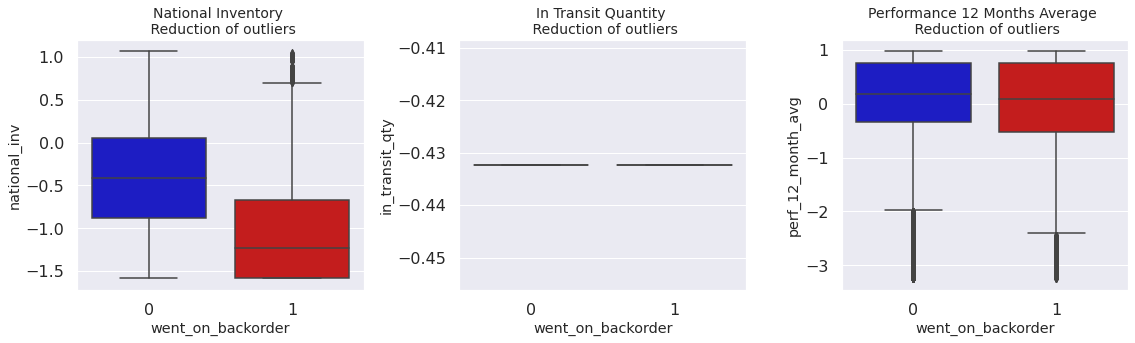

In [32]:
f, axes = plt.subplots(ncols=3, figsize=(16,5))

# Negative Correlations with our went_on_backorder (The lower our feature value the more likely it will be a backorder transaction)
sns.boxplot(x="went_on_backorder", y="national_inv", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('National Inventory \n Reduction of outliers', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=16)
sns.boxplot(x="went_on_backorder", y="in_transit_qty", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('In Transit Quantity \n Reduction of outliers', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=16)
sns.boxplot(x="went_on_backorder", y="perf_12_month_avg", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Performance 12 Months Average \n Reduction of outliers', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

In [33]:
# # -----> Removing Outliers (Highest Positive Correlated with Labels)
for i in ['forecast_3_month','sales_9_month','pieces_past_due','local_bo_qty']:
    forecast_3_month_backorder = new_df[i].loc[new_df['went_on_backorder'] == 1].values
    q25, q75 = np.percentile(forecast_3_month_backorder, 25), np.percentile(forecast_3_month_backorder, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    forecast_3_month_iqr = q75 - q25
    print('iqr: {}'.format(forecast_3_month_iqr))

    forecast_3_month_cut_off = forecast_3_month_iqr * 1.5
    forecast_3_month_lower, forecast_3_month_upper = q25 - forecast_3_month_cut_off, q75 + forecast_3_month_cut_off
    print('Cut Off: {}'.format(forecast_3_month_cut_off))
    print('{} Lower: {}'.format(i,forecast_3_month_lower))
    print('{} Upper: {}'.format(i,forecast_3_month_upper))

    outliers = [x for x in forecast_3_month_backorder if x < forecast_3_month_lower or x > forecast_3_month_upper]
    print('Feature {} Outliers for backorder Cases: {}'.format(i,len(outliers)))
    print('{} outliers:{}'.format(i,outliers))

    new_df = new_df.drop(new_df[(new_df[i] > forecast_3_month_upper) | (new_df[i] < forecast_3_month_lower)].index)
    print('----' * 44)


print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -0.0353633960451977 | Quartile 75: 1.0182462323768315
iqr: 1.0536096284220293
Cut Off: 1.580414442633044
forecast_3_month Lower: -1.6157778386782418
forecast_3_month Upper: 2.5986606750098753
Feature forecast_3_month Outliers for backorder Cases: 136
forecast_3_month outliers:[3.404100261062261, 2.8185147509081663, 3.908080659632771, 2.888270976126227, 2.7253238099159214, 2.722478911286143, 2.632496216830333, 4.289344495470538, 2.6801817754911434, 2.714423796416521, 3.403817912250768, 3.5597427953160707, 2.675805972773061, 3.092687488482217, 2.785555734443225, 3.0031983483928144, 5.006467210506663, 3.561279162910712, 2.814750807591546, 3.0098929149631197, 2.934735759413757, 3.119207426092703, 2.8076141801162477, 3.5145217214435185, 2.64603103018346, 3.333781889363574, 3.2027331897765925, 2.8076141801162477, 2.964466493228684, 2.99084582196398, 3.1107841678734385, 3.7466415323562186, 2.65984971973149, 3.162755527360979, 3.403817912250768, 2.714423796416521, 4.27817980981815

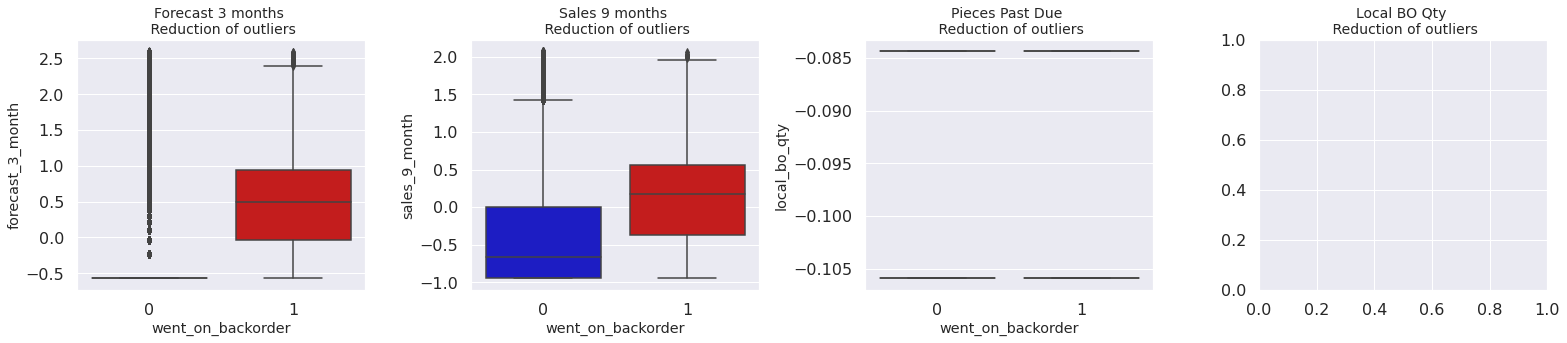

In [36]:
f, axes = plt.subplots(ncols=4, figsize=(22,5))

# Negative Correlations with our went_on_backorder (The lower our feature value the more likely it will be a backorder transaction)
sns.boxplot(x="went_on_backorder", y='forecast_3_month', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Forecast 3 months \n Reduction of outliers', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=16)
sns.boxplot(x="went_on_backorder", y="sales_9_month", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Sales 9 months \n Reduction of outliers', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=16)
sns.boxplot(x="went_on_backorder", y="pieces_past_due", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Pieces Past Due \n Reduction of outliers', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=16)
sns.boxplot(x="went_on_backorder", y="local_bo_qty", data=new_df, palette=colors, ax=axes[2])
axes[3].set_title('Local BO Qty \n Reduction of outliers', fontsize=14)
axes[3].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

## Dimensionality reduction
**Understanding t-SNE:**\
In order to understand this algorithm you have to understand the following terms:
1. Euclidean Distance
2. Conditional Probability
3. Normal and T-Distribution Plots
Note: If you want a simple instructive video look at StatQuest: t-SNE, Clearly Explained by Joshua Starmer

**Summary:**
1. t-SNE algorithm can pretty accurately cluster the cases that were Backorder and non-Backorder in our dataset.
2. Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)
3. This gives us an indication that further predictive models will perform pretty well in separating Backorder cases from non-Backorder cases.

In [83]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('went_on_backorder', axis=1)
y = new_df['went_on_backorder']

import time
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.5e+02 s
PCA took 0.34 s
Truncated SVD took 0.31 s


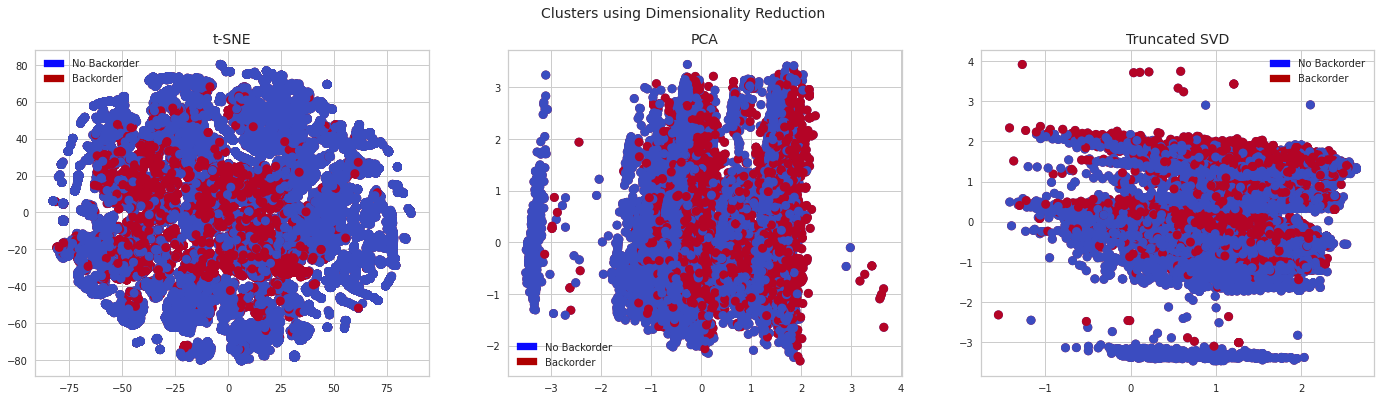

In [84]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Backorder', 'Backorder']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Backorder')
red_patch = mpatches.Patch(color='#AF0000', label='Backorder')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Backorder', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Backorder', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Backorder', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Backorder', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Backorder', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Backorder', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()